# Portfolio Risk Demo

This notebook demonstrates `options_pricing.risk`:
- Portfolio Greeks aggregation (Δ, Γ, Θ, ν, ρ)
- Scenario shocks (Taylor vs Full Revaluation)
- P&L attribution (pathwise/Shapley-style)
- Stress testing grid
- Historical and Monte Carlo VaR/ES

**Assumption:** your package is importable as `options_pricing` from the project root.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman" # Set font to Times New Roman
import sys
import os
# Add the repo root (one level up from notebooks) to Python path
repo_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(repo_root)

from options_pricing.risk import (
    aggregate_greeks, scenario_pnl_delta_gamma, scenario_revalue,
    pnl_attribution_first_order, historical_var_es, mc_var_es, stress_grid
)

## 1) Define a sample portfolio
Two option positions with different strikes/vols/sides to create non-trivial risk.


In [5]:
positions = [
    {"option": "call", "side": +1, "quantity": 2, "S": 100.0, "K": 100.0, "T": 0.50, "r": 0.03, "sigma": 0.20, "multiplier": 100},
    {"option": "put",  "side": -1, "quantity": 1, "S": 100.0, "K": 95.0,  "T": 0.50, "r": 0.03, "sigma": 0.22, "multiplier": 100},
]


## 2) Aggregate portfolio Greeks
We compute Δ, Γ, Θ, ν, ρ for the entire portfolio and the current marked value.

- **Units:** ν per 1.00 vol (×0.01 for 1 vol-pt), Θ per **year**, ρ per 1.00 rate.


In [6]:
agg = aggregate_greeks(positions)
agg

{'delta': np.float64(144.74710734110852),
 'gamma': np.float64(3.295726246614473),
 'theta': np.float64(-970.2828554269419),
 'vega': np.float64(3069.85623647759),
 'rho': np.float64(6766.716839358975),
 'value': np.float64(941.2770553929001)}

## 3) Scenario shocks: Taylor vs Full Revaluation
Compare the 2nd-order Taylor approximation (Δ–Γ + ν/ρ/Θ) with full repricing.


In [7]:
scenarios = [
    {"name": "+$1 spot",          "dS": 1.0,  "dSigma": 0.00,  "dR": 0.00,  "dT": 0.0},
    {"name": "+1 vol-pt",         "dS": 0.0,  "dSigma": 0.01,  "dR": 0.00,  "dT": 0.0},
    {"name": "+$1 & +1 vol-pt",   "dS": 1.0,  "dSigma": 0.01,  "dR": 0.00,  "dT": 0.0},
    {"name": "−1 day carry",      "dS": 0.0,  "dSigma": 0.00,  "dR": 0.00,  "dT": -1.0/252.0},
]
rows = []
for sc in scenarios:
    taylor = scenario_pnl_delta_gamma(positions, **{k: sc.get(k, 0.0) for k in ("dS","dSigma","dR","dT")})
    full   = scenario_revalue(positions, **{k: sc.get(k, 0.0) for k in ("dS","dSigma","dR","dT")})
    rows.append({**sc, "Taylor": taylor, "FullReval": full, "Error": full - taylor})
pd.DataFrame(rows)

,name,dS,dSigma,dR,dT,Taylor,FullReval,Error
0,+$1 spot,1.0,0.00,0.0,0.000000,146.394970,146.389304,-0.005666
1,+1 vol-pt,0.0,0.01,0.0,0.000000,30.698562,30.611524,-0.087038
2,+$1 & +1 vol-pt,1.0,0.01,0.0,0.000000,177.093533,177.320351,0.226818
3,−1 day carry,0.0,0.00,0.0,-0.003968,3.850329,-3.855175,-7.705504


## 4) P&L attribution between two states
We attribute the P&L from a start state to an end state using the pathwise/Shapley-style method
implemented in `pnl_attribution_first_order`.

**Move:** ΔS = +0.1, Δσ = +0.005 (applied uniformly to each leg), Δr = +0.001, ΔT = −1/252.


In [8]:
S0, sigma0, r0, T0 = 100.0, 0.20, 0.03, 0.50
S1, sigma1, r1, T1 = 100.1, 0.205, 0.031, T0 - 1.0/252.0

attr = pnl_attribution_first_order(positions, S0, sigma0, r0, T0, S1, sigma1, r1, T1)
attr, abs(attr["residual"]) / max(1.0, abs(attr["total"]))

({'delta': np.float64(14.50129203317988),
  'gamma': 0.0,
  'vega': np.float64(15.337211115344985),
  'volga': 0.0,
  'vanna': 0.0,
  'rho': np.float64(6.787718604623933),
  'theta': np.float64(-3.972081047676852),
  'residual': np.float64(0.0),
  'total': np.float64(32.654140705471946)},
 np.float64(0.0))

## 5) Stress test grid
Generate a grid over spot/vol/rate shocks (with time decay) and visualize the P&L surface.


In [9]:
grid = stress_grid(
    positions,
    S_moves=(-0.2, -0.1, 0.0, 0.1, 0.2),
    vol_moves=(-0.2, -0.1, 0.0, 0.1, 0.2),
    r_moves=(-0.01, 0.0, 0.01),
    horizon_days=1
)
grid.head()

,S_move,vol_move,r_move,horizon_days,PnL
0,-0.2,-0.2,-0.01,1,-2369.274947
1,-0.2,-0.2,0.00,1,-2324.216668
2,-0.2,-0.2,0.01,1,-2279.408035
3,-0.2,-0.1,-0.01,1,-2373.914388
4,-0.2,-0.1,0.00,1,-2328.474927


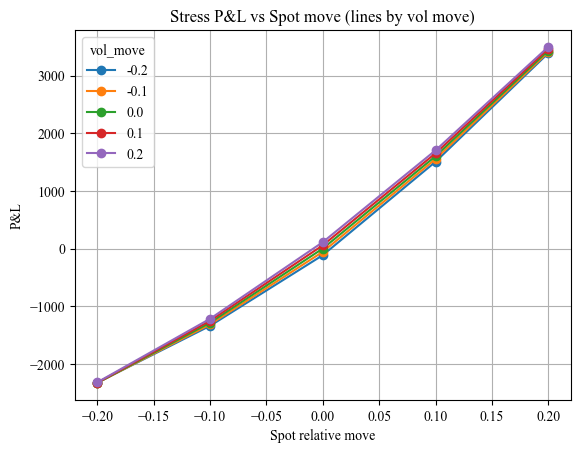

In [10]:
# Visualize as lines vs spot move (one line per vol move).
pivot = grid.pivot_table(index="S_move", columns="vol_move", values="PnL", aggfunc="mean")
fig = plt.figure()
pivot.plot(ax=plt.gca(), marker='o')  # do not set colors explicitly
plt.title("Stress P&L vs Spot move (lines by vol move)")
plt.xlabel("Spot relative move")
plt.ylabel("P&L")
plt.grid(True)
plt.show()

## 6) Historical VaR/ES
Using synthetic daily returns for illustration. Replace `rets` with your historical series.


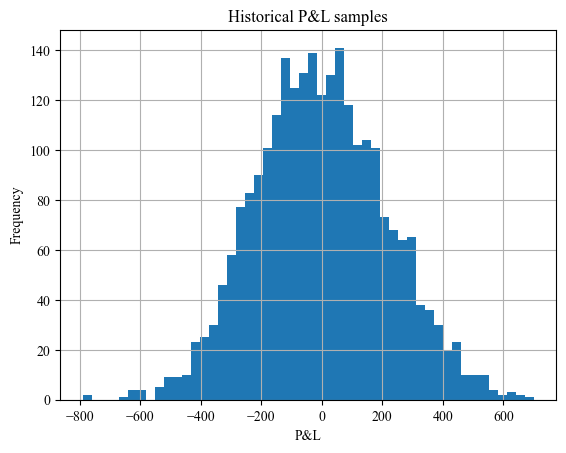

In [12]:
rng = np.random.default_rng(0)
rets = rng.normal(0.0, 0.015, size=2500)  # ~10 years of trading days
hist = historical_var_es(rets, positions, alpha=0.99)
hist["VaR"], hist["ES"]
# Plot historical P&L distribution
fig = plt.figure()
plt.hist(hist["pnl_samples"], bins=50)
plt.title("Historical P&L samples")
plt.xlabel("P&L")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

## 7) Monte Carlo VaR/ES
Compare delta–gamma approximation vs full revaluation under a simple Gaussian daily return model.


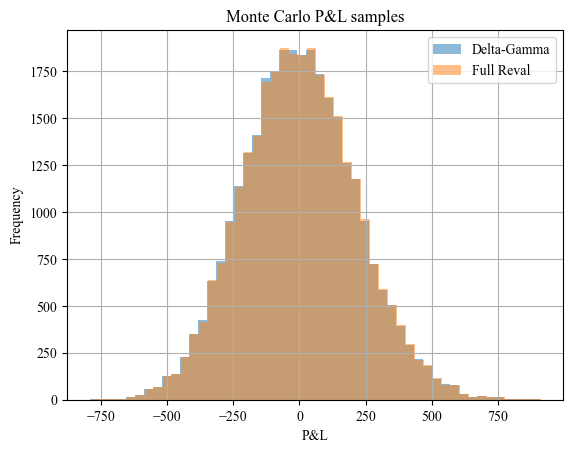

In [14]:
mc_dg = mc_var_es(positions, n_sims=30000, sigma_ret=0.015, alpha=0.99, method="delta_gamma", seed=1)
mc_fr = mc_var_es(positions, n_sims=30000, sigma_ret=0.015, alpha=0.99, method="full_reval",  seed=1)
(mc_dg["VaR"], mc_dg["ES"]), (mc_fr["VaR"], mc_fr["ES"])

# Plot MC P&L distributions
fig = plt.figure()
plt.hist(mc_dg["pnl_samples"], bins=50, alpha=0.5, label="Delta-Gamma")
plt.hist(mc_fr["pnl_samples"], bins=50, alpha=0.5, label="Full Reval")
plt.title("Monte Carlo P&L samples")
plt.xlabel("P&L")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()